In [13]:
# Importaciones básicas y manejo de datos
import pandas as pd
import numpy as np
from math import pi  

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning y análisis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score



In [14]:

# ========================
# 1. Cargar datos desde un CSV limpio
# ========================
df = pd.read_csv("luminarias_limpias.csv")

# Mostrar las primeras filas para validar la carga
df.head()

,tipo,potencia_watts,altura_metros,estado,sensores_luminosidad_lux,sensores_movimiento,sensores_temperatura_c,sensores_humedad_pct,eficiencia_lumens_por_watt,eficiencia_vida_util_restante_pct,registro_fecha_instalacion
0,Halógena,150,6.56,Fallando,101,True,23.6,59.4,100.87,82.9,2024-11-18
1,Incandescente,75,6.89,Encendida,125,False,34.8,50.0,96.66,50.9,2024-01-20
2,Halógena,150,7.47,Encendida,156,True,25.3,64.2,115.65,53.3,2025-04-16
3,Halógena,75,8.47,Apagada,179,False,27.8,52.8,113.91,38.0,2025-03-20
4,Halógena,100,8.84,Apagada,248,False,29.6,40.6,118.38,77.7,2024-11-29


In [15]:

features = [
    "potencia_watts",
    "altura_metros",
    "sensores_luminosidad_lux",
    "sensores_temperatura_c",
    "sensores_humedad_pct",
    "eficiencia_lumens_por_watt",
    "eficiencia_vida_util_restante_pct"
]
# Limpieza de datos
df_clean = df.dropna(subset=features)
X = df_clean[features]

# Estandarización de los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


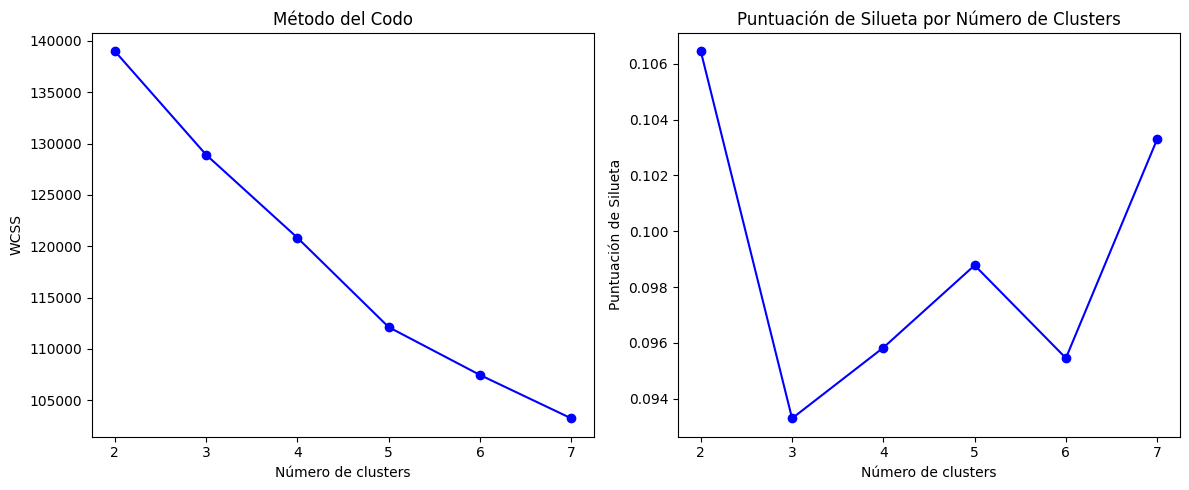

In [16]:
# Determinación del número óptimo de clusters
# Método del codo para determinar el número óptimo de clusters
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 8)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método del Codo')

# Graficar puntuaciones de silueta
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de Silueta')
plt.title('Puntuación de Silueta por Número de Clusters')
plt.tight_layout()
plt.show()

In [17]:
#Aplicación de K-Means con el número óptimo de clusters
# Elegir el número óptimo de clusters basado en los gráficos
optimal_clusters = 3  

# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Añadir los clusters al dataframe
df_clean['cluster'] = clusters

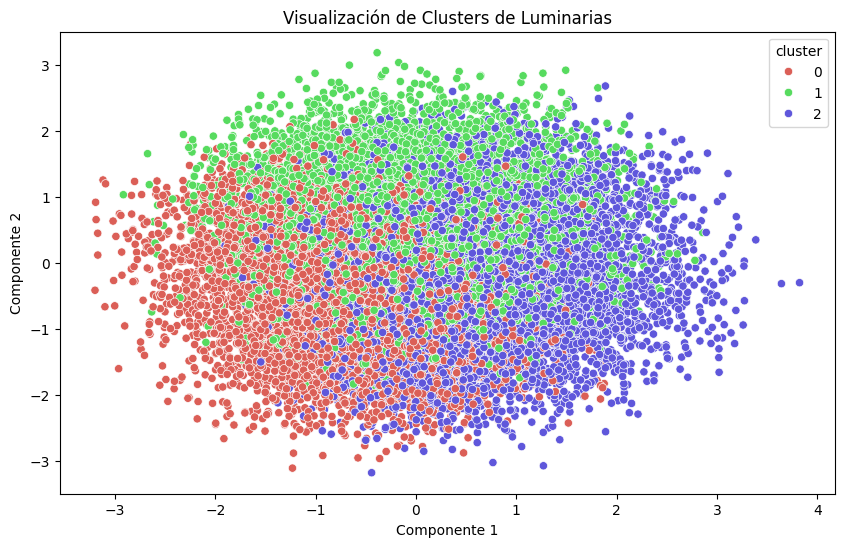

In [18]:
#Visualizacion
# Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear dataframe para visualización
df_viz = pd.DataFrame(X_pca, columns=['Componente 1', 'Componente 2'])
df_viz['cluster'] = clusters

# Visualizar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Componente 1', y='Componente 2',
    hue='cluster', 
    palette=sns.color_palette("hls", optimal_clusters),
    data=df_viz,
    legend="full"
)
plt.title('Visualización de Clusters de Luminarias')
plt.show()

Características promedio por cluster:
         potencia_watts  altura_metros  sensores_luminosidad_lux  \
cluster                                                            
0             92.166213       9.143948                208.219346   
1             94.391382       7.007791                228.816378   
2             94.829490       7.786196                100.075074   

         sensores_temperatura_c  sensores_humedad_pct  \
cluster                                                 
0                     27.780477             60.163147   
1                     27.510647             59.614512   
2                     27.347424             60.030373   

         eficiencia_lumens_por_watt  eficiencia_vida_util_restante_pct  
cluster                                                                 
0                        110.954489                          61.075954  
1                        109.870871                          60.485340  
2                        109.372594        

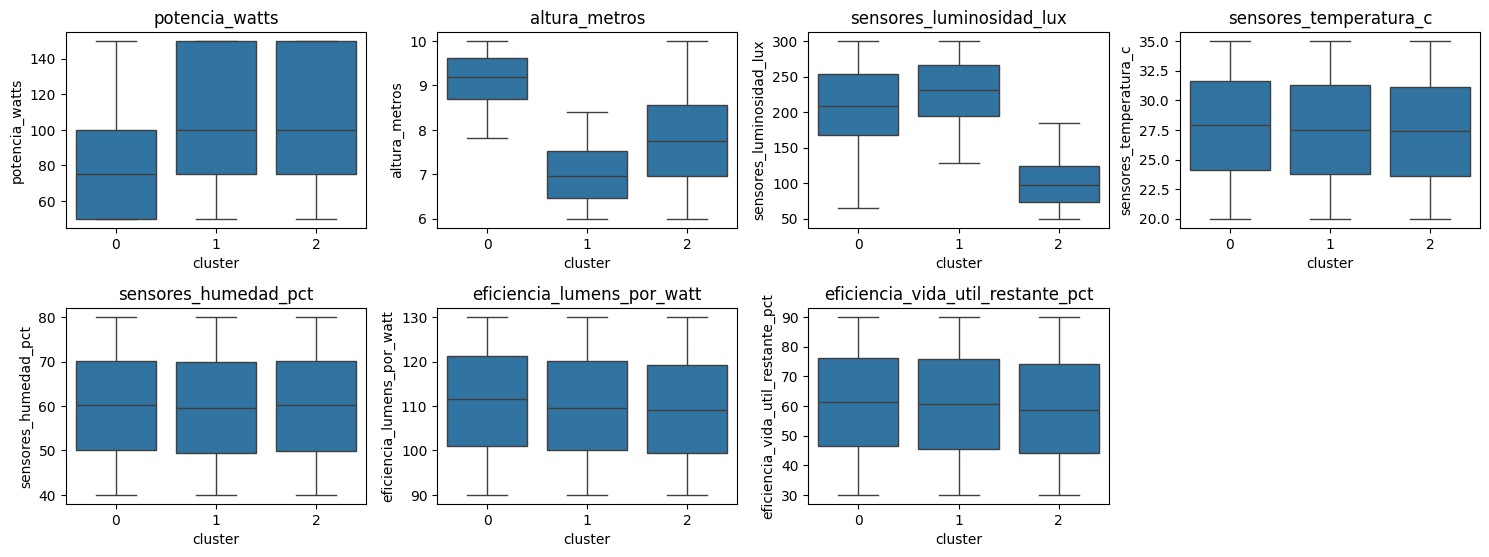

In [19]:
#Analisis de Clusters
# Estadísticas descriptivas por cluster
cluster_stats = df_clean.groupby('cluster')[features].mean()

# Mostrar estadísticas
print("Características promedio por cluster:")
print(cluster_stats)

# Visualización de características importantes por cluster
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='cluster', y=feature, data=df_clean)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [20]:
#Interpretacion de clusters
# Interpretar los clusters basado en las características
cluster_interpretation = {
    0: "Luminarias de alto consumo y baja eficiencia",
    1: "Luminarias eficientes con buen estado",
    2: "Luminarias con problemas de conectividad y mantenimiento"
}

df_clean['cluster_interpretation'] = df_clean['cluster'].map(cluster_interpretation)

# Mostrar distribución de clusters
print("\nDistribución de clusters:")
print(df_clean['cluster_interpretation'].value_counts())

# Guardar resultados para el frontend
df_clean.to_csv('luminarias_clusters.csv', index=False)


Distribución de clusters:
cluster_interpretation
Luminarias con problemas de conectividad y mantenimiento    8152
Luminarias de alto consumo y baja eficiencia                7340
Luminarias eficientes con buen estado                       6753
Name: count, dtype: int64


## 3. Gráfico de Barras Apiladas por Estado de Mantenimiento


<Figure size 1000x600 with 0 Axes>

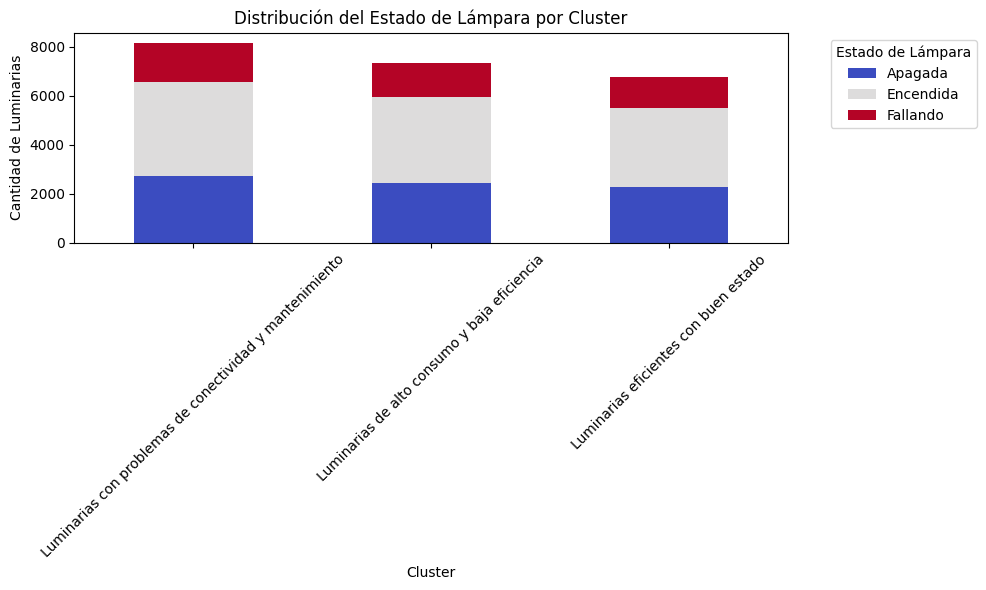

In [21]:
plt.figure(figsize=(10, 6))
cross_tab = pd.crosstab(df_clean['cluster_interpretation'], df_clean['estado'])
cross_tab.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.title('Distribución del Estado de Lámpara por Cluster')
plt.ylabel('Cantidad de Luminarias')
plt.xlabel('Cluster')
plt.xticks(rotation=45)
plt.legend(title='Estado de Lámpara', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [22]:
# Exportar el DataFrame con los clusters a JSON
df_clean.to_json('luminarias_clusters.json', orient='records', indent=4)
print("✅ Datos exportados a 'luminarias_clusters.json'")

✅ Datos exportados a 'luminarias_clusters.json'
